![logo](./img/LogoLine_horizon_CAMS.png)

# Create Maps from CAMS Data

This tutorial demonstrates how to visualise data from the [Copernicus Atmosphere Monitoring Service (CAMS)](https://atmosphere.copernicus.eu/) in the form of two dimensional maps.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=vis-maps.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/vis-maps.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/vis-maps.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<br>

## Install and import packages

In [ ]:
!pip install cdsapi

In [2]:
# CDS API
import cdsapi

# Library to extract data
from zipfile import ZipFile

# Libraries for reading and working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

## Access data

Copy your API key into the code cell below, replacing `#######` with your key. (Remember, to access data from the ADS, you will need first to register/login https://ads-beta.atmosphere.copernicus.eu/ and obtain an API key from https://ads-beta.atmosphere.copernicus.eu/how-to-api.)

In [3]:
URL = 'https://ads-beta.atmosphere.copernicus.eu/api'

# Replace the hashtags with your key:
KEY = '#################################'

Here we specify a data directory into which we will download our data and all output files that we will generate:

In [4]:
DATADIR = '.'

For our first plotting example, we will use CAMS Global Atmospheric Composition Forecast data. The code below shows the subset characteristics that we will extract from this dataset for the purpose of this tutorial as an API request.

```{note}
Before running this code, ensure that you have **accepted the terms and conditions**. This is something you only need to do once for each CAMS dataset. You will find the option to do this by selecting the dataset in the ADS, then scrolling to the end of the *Download data* tab.
```

In [5]:
dataset = "cams-global-atmospheric-composition-forecasts"
request = {
    'variable': ['dust_aerosol_optical_depth_550nm', 'organic_matter_aerosol_optical_depth_550nm', 'total_aerosol_optical_depth_550nm'],
    'date': ['2021-08-01/2021-08-01'],
    'time': ['12:00'],
    'leadtime_hour': ['0'],
    'type': ['forecast'],
    'data_format': 'netcdf_zip',
}

client = cdsapi.Client(url=URL, key=KEY)
client.retrieve(dataset, request).download(f'{DATADIR}/2021-08-01_AOD.zip')

2024-09-12 13:40:19,868 INFO Request ID is 937c7244-9c6f-436a-a448-2f0440178173
2024-09-12 13:40:20,050 INFO status has been updated to accepted
2024-09-12 13:40:21,742 INFO status has been updated to running
2024-09-12 13:40:24,203 INFO Creating download object as zip with files:
['data_sfc.nc']
2024-09-12 13:40:27,753 INFO status has been updated to successful


5db6c7815581e4cc3c708982a4e8911c.zip:   0%|          | 0.00/2.84M [00:00<?, ?B/s]

'./2021-08-01_AOD.zip'

## Read data

First we extract the downloaded zip file:

In [6]:
# Create a ZipFile Object and load zip file in it
with ZipFile(f'{DATADIR}/2021-08-01_AOD.zip', 'r') as zipObj:
   # Extract all the contents of zip file into a directory
   zipObj.extractall(path=f'{DATADIR}/2021-08-01_AOD/')

For convenience, we create a variable with the name of our downloaded file:

In [7]:
fn = f'{DATADIR}/2021-08-01_AOD/data_sfc.nc'

Now we can read the data into an Xarray dataset:

In [8]:
# Create Xarray Dataset
ds = xr.open_dataset(fn)
ds

<xarray.Dataset> Size: 5MB
Dimensions:                  (forecast_period: 1, forecast_reference_time: 1,
                              latitude: 451, longitude: 900)
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 8B 00:00:00
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2021...
  * latitude                 (latitude) float64 4kB 90.0 89.6 ... -89.6 -90.0
  * longitude                (longitude) float64 7kB 0.0 0.4 0.8 ... 359.2 359.6
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] 8B ...
Data variables:
    duaod550                 (forecast_period, forecast_reference_time, latitude, longitude) float32 2MB ...
    omaod550                 (forecast_period, forecast_reference_time, latitude, longitude) float32 2MB ...
    aod550                   (forecast_period, forecast_reference_time, latitude, longitude) float32 2MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-12T13:40 GRIB to CDM+CF via cfgrib-0.9.1...

## Plot data

There are several ways we can visualise this data in a plot. To create a static plot of one variable for one timestep, we will first create an xarray *Data Array* which includes only one variable. In this case, we will focus on *Total AOD at 550 nm*, or `aod550` (this is how the variable is named in our xarray *Dataset*).

In [9]:
# Create Xarray Data Array
da = ds['aod550']
da

<xarray.DataArray 'aod550' (forecast_period: 1, forecast_reference_time: 1,
                            latitude: 451, longitude: 900)> Size: 2MB
[405900 values with dtype=float32]
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 8B 00:00:00
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2021...
  * latitude                 (latitude) float64 4kB 90.0 89.6 ... -89.6 -90.0
  * longitude                (longitude) float64 7kB 0.0 0.4 0.8 ... 359.2 359.6
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] 8B ...
Attributes: (12/33)
    GRIB_paramId:                             210207
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      405900
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_units:                               ~
    long_name:                                Total Aerosol Optical Depth at ...
    units:                                    ~
    standard_name:                            unknown
    GRIB_number:                              0
    GRIB_surface:                             0.0

### Simple plot using xarray

A very simple way to visualise this data is to use xarray's own plotting functionality. This can be done with the `.plot()` method:

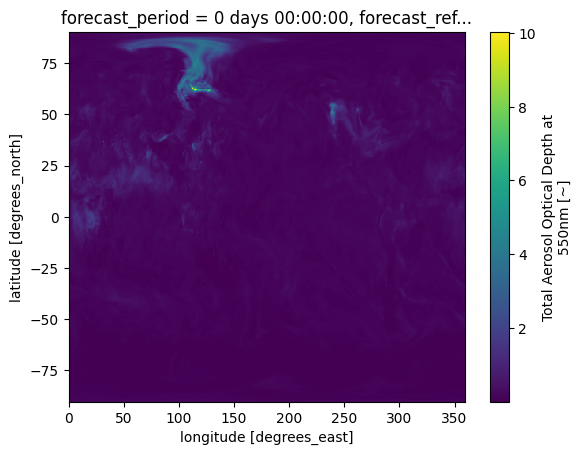

In [10]:
da.plot()

This figure would be easier to interpret with some modifications. These may include adjusting the colourscale, or adding annotations such as coastlines. While xarray's plotting functionality can be further customised, it is essentially a thin wrapper around the popular [matplotlib](https://matplotlib.org/) library. The example below shows how to generate a more customised visualisation using both matplotlib (for visualisations) and [cartopy](https://pypi.org/project/Cartopy/) (for geospatial data processing).

### Customised map with matplotlib and cartopy

/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


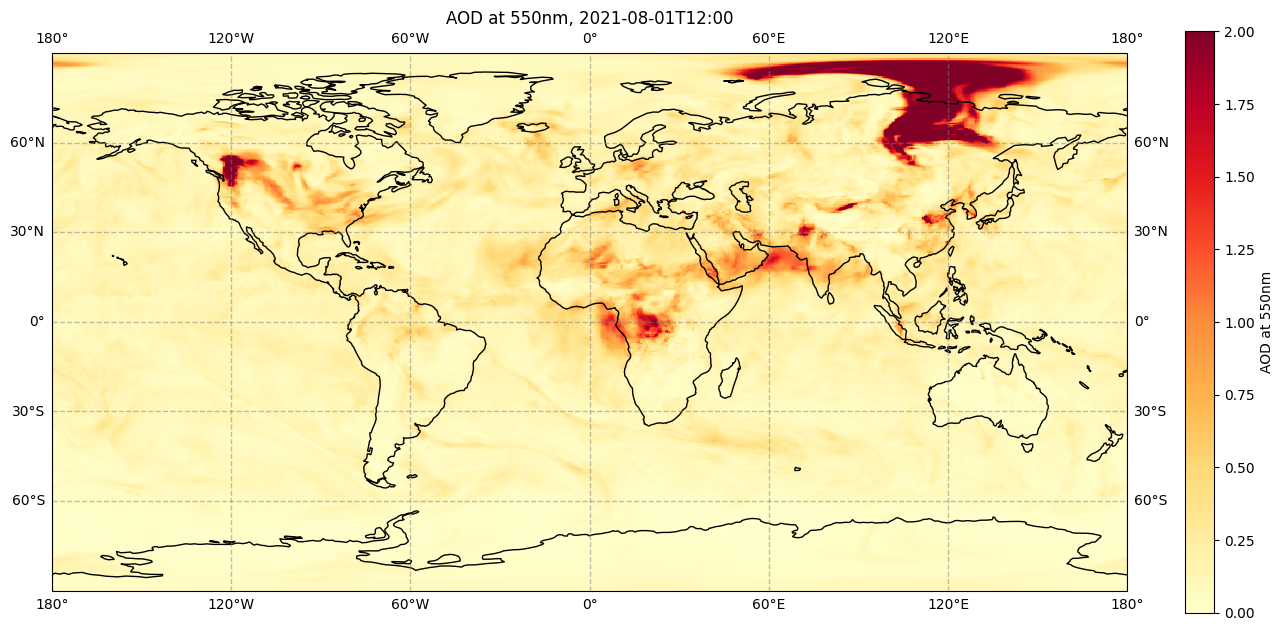

In [12]:
# create the figure panel and specify size
fig = plt.figure(figsize=(15, 10))

# create the map using the cartopy PlateCarree projection
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Add lat/lon grid
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set figure title
ax.set_title('AOD at 550nm, 2021-08-01T12:00', fontsize=12) 

# Plot the data
im = plt.pcolormesh(da.longitude, da.latitude, da[0,0,:,:], cmap='YlOrRd', vmin=0, vmax=2) 

# Add coastlines
ax.coastlines(color='black') 

# Specify the colourbar, including fraction of original axes to use for colorbar, 
# and fraction of original axes between colorbar and new image axes
cbar = plt.colorbar(im, fraction=0.025, pad=0.05) 

# Define the colourbar label
cbar.set_label('AOD at 550nm') 

# Save the figure
fig.savefig(f'{DATADIR}/CAMS_global_forecast_AOD_2021-08-01.png')

The colours used in the above figure are from one of many [built-in colourmaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) used in matplotlib. We can also create our own colourmap. The code below shows how to create the same colourmap as used in many CAMS products, such as the [CAMS aerosol forecasts](https://atmosphere.copernicus.eu/charts/cams/aerosol-forecasts).

### Create custom colourmap

In [13]:
# This code creates a colourmap similar to that used in CAMS products.

# Import the Matplotlib class 'ListedColormap' to generate a colormap object from a given list of colours
from matplotlib.colors import ListedColormap

# Array containing 15 colours ranging from white, grey, yellow and orange to red.
# Each row in the array contains three numbers for red, green and blue respectively.
# The numbers represent intensity, from 0 (black) to 256 (white).
matrix = np.array([[256, 256, 256],
                   [210, 214, 234],
                   [167, 174, 214],
                   [135, 145, 190],
                   [162, 167, 144],
                   [189, 188, 101],
                   [215, 209, 57],
                   [242, 230, 11],
                   [243, 197, 10],
                   [245, 164, 8],
                   [247, 131, 6],
                   [248, 98, 5],
                   [250, 65, 3],
                   [252, 32, 1],
                   [254, 0, 0]])
n = 17 # Multiplication number

cams = np.ones((253, 4)) # Initial empty colormap, to be filled by the colours in 'matrix'.

# This loop fills in the empty 'cams' colormap with each of the 15 colours in 'matrix'
# multiplied by 'n'. Each colour is divided by 256 to normalise from 0 (black) to 1 (white). 
for i in range(matrix.shape[0]):
    cams[(i*n):((i+1)*n),:] = np.array([matrix[i,0]/256, matrix[i,1]/256, matrix[i,2]/256, 1])

# The final colormap is given by 'camscmp', which uses the Matplotlib class 'ListedColormap(Colormap)'
# to generate a colormap object from the list of colours provided by 'cams'.
camscmp = ListedColormap(cams)

We now apply this custom colourmap to the same code above to generate the same figure, but with the CAMS colourmap. Note the only difference between this and the above visualisation code (apart from removing the comments) is to replace in the `plt.pcolormesh()` function, `cmap='YlOrRd'` (the standard yellow-orange-red matplotlib colourmap) with `cmap=camscmp` (our custom-made CAMS colourmap).

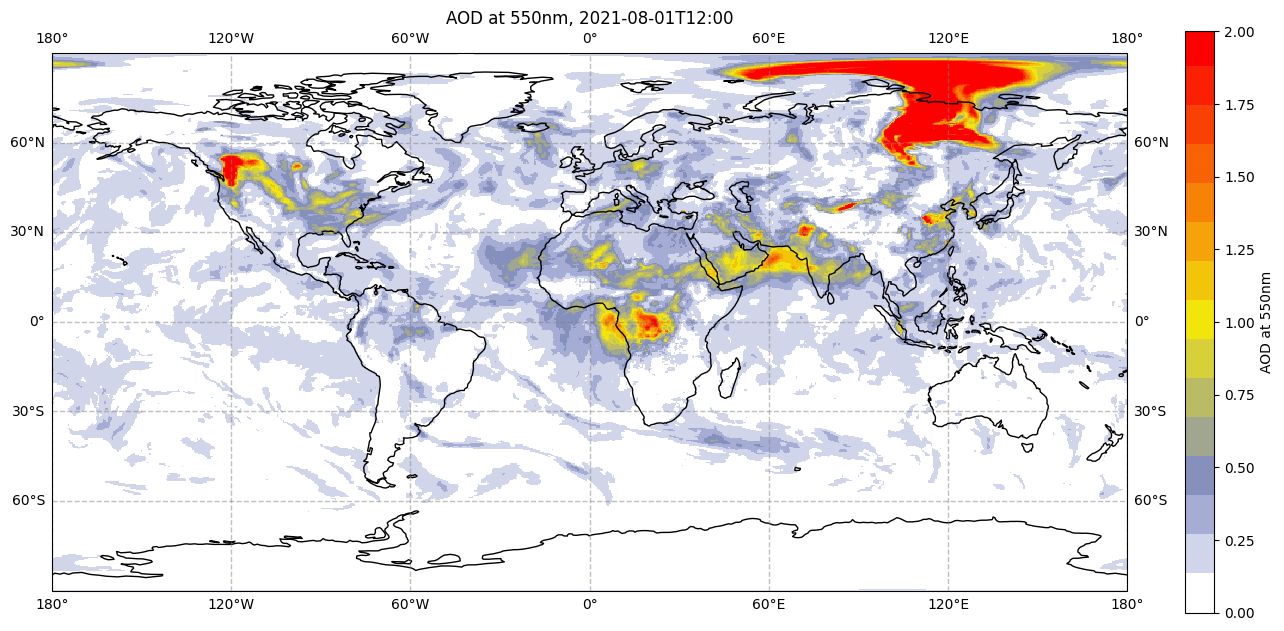

In [14]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.set_title('AOD at 550nm, 2021-08-01T12:00', fontsize=12) 
im = plt.pcolormesh(da.longitude, da.latitude, da[0,0,:,:], cmap=camscmp, vmin=0, vmax=2) 
ax.coastlines(color='black') 
cbar = plt.colorbar(im, fraction=0.025, pad=0.05)
cbar.set_label('AOD at 550nm') 
fig.savefig(f'{DATADIR}/CAMS_global_forecast_AOD_2021-08-01_CAMS-cmap.png')

### Create subplots

The examples above demonstrate how to create a single map. However, we may want to create multiple maps or plots in the same figure, for example to compare maps of different variables side by side. The example below shows one way to do this.

In [15]:
# Here we extract the names of the variables from the xarray Dataset

variables = list(ds.keys())
variables

['duaod550', 'omaod550', 'aod550']

In [16]:
# We would like to change the order in which variables are visualised, 
# beginning with Total AOD (last in the list, becomes first), 
# then breaking this down into Dust AOD (order remains the same), 
# and Organic Matter AOD (first in the list, becomes last).

variables[0], variables[2] = variables[2], variables[0]

Having extracted the names of variables, inserted them into the right order, we can now loop through them to produce a single figure with subplots containing maps of each variable side-by-side. Given that most AOD concentration in this data is in the Northern Hemisphere, we will also change the projection from PlateCarree to Orthographic, centred at 90 degrees north.

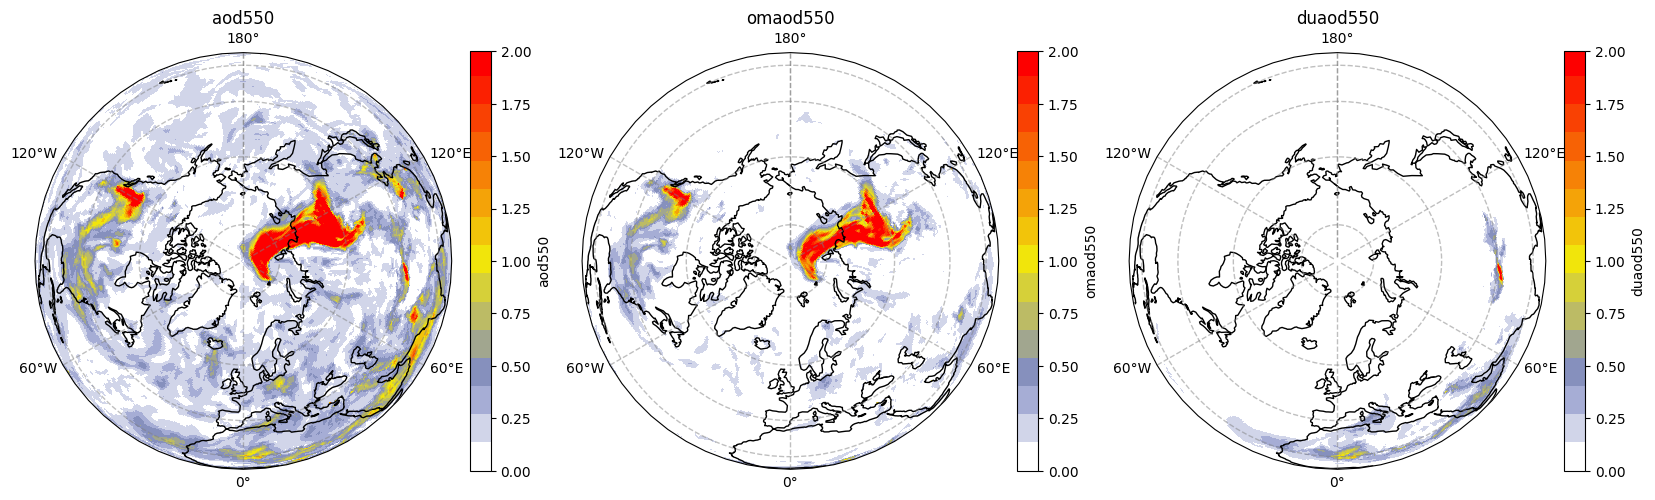

In [17]:
fig, axs = plt.subplots(1, 3, figsize = (20, 10), subplot_kw={'projection': ccrs.Orthographic(central_latitude=90)})

for i in range(3):
    da = ds[variables[i]]
    axs[i].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
    axs[i].set_title(f'{variables[i]}', fontsize=12) # Set figure title
    im = axs[i].pcolormesh(da.longitude, da.latitude, da[0,0,:,:],
                            transform = ccrs.PlateCarree(), cmap=camscmp, vmin=0, vmax=2)
    axs[i].coastlines(color='black') # Add coastlines
    cbar = fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04) # Specify the colourbar
    cbar.set_label(variables[i]) # Define the colourbar label

plt.show() # Display the figure
fig.savefig(f'{DATADIR}/AOD_NHem.png') # Save the figure

We can see that the high values of AOD seem to be mainly due to organic matter in North America and Siberia, which saw many wildfire activity in this period, while further south we can see a dust contribution.